In [1]:
import librosa
import librosa.display
import os
import io
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import pandas as pd
import csv
from time import process_time
import scipy
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')


In [2]:
tar = dict()
tsv_file = open("targets.tsv")
read_tsv = csv.reader(tsv_file, delimiter="\t")
for row in read_tsv: 
    tar[row[0]+'.wav'] = row[1]
tsv_file.close()

In [3]:
def load(directory, tar, target):
    feature = []
    if target!='test': Y = []
    for mfile in os.listdir(directory): 
        if (mfile == '.DS_Store')or(mfile == 'targets.tsv'): continue
        y, sr = librosa.load('./'+ directory + '/' +os.fspath(mfile), sr = None)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        yt, index = librosa.effects.trim(y,  top_db=np.std(D))
        s = librosa.feature.melspectrogram(y=yt, sr=sr)
        feature.append(s)
        if target!='test': Y.append(int(tar[mfile]))
    if target=='test': return feature
    else: return feature, Y

def load_cut(directory, tar, target, t_max):
    feature = []
    if target!='test': Y = []
    for mfile in os.listdir(directory): 
        if (mfile == '.DS_Store')or(mfile == 'targets.tsv'): continue
        y, sr = librosa.load('./'+ directory + '/' +os.fspath(mfile), sr = None)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        yt, index = librosa.effects.trim(y,  top_db=np.std(D))
        #spectogram
        s = librosa.feature.melspectrogram(y=yt, sr=sr)
#         print(s.shape)
        if (s.shape[1]>=t_max): 
            s = s[:, :t_max]
            feature.append(s)
        else:
            z = np.zeros((s.shape[0], t_max-s.shape[1]))
            s = np.concatenate((s, z), axis=1)
            feature.append(s)
        #other features
#         spec_centroid = librosa.feature.spectral_centroid(y=yt, sr=sr)
#         chroma_stft = librosa.feature.chroma_stft(y=yt, sr=sr)
#         spec_bw = librosa.feature.spectral_bandwidth(y=yt, sr=sr)
#         print(spec_centroid.shape)
#         print(chroma_stft.shape)
#         print(spec_bw.shape)
        if target!='test': Y.append(int(tar[mfile]))
    if target=='test': return feature
    else: return feature, Y

(57344,) 16000
14.449923
(18432,) (18432,)


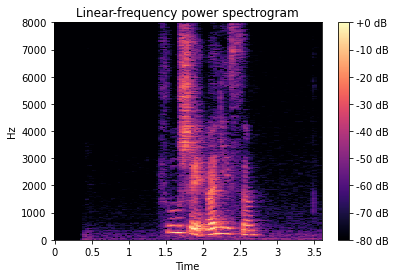

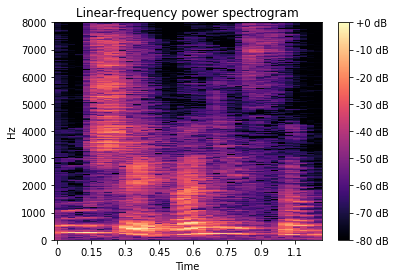

In [4]:
directory = 'train'
for mfile in os.listdir(directory)[:1]: 
    if mfile == '.DS_Store': continue
    y, sr = librosa.load('./'+ directory + '/' +os.fspath(mfile), sr = None)

print(y.shape, sr)

def plot_spec(y, sr, log):
    if log == True: rows = 2
    else: rows = 1
    fig, ax = plt.subplots(nrows=rows, ncols=1, sharex=True)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
    ax.set(title='Linear-frequency power spectrogram')
    ax.label_outer()

    if log == True:
        hop_length = 1024
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),ref=np.max)
        librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,x_axis='time', ax=ax[1])
        ax[1].set(title='Log-frequency power spectrogram')
        ax[1].label_outer()
    fig.colorbar(img, ax=ax, format="%+2.f dB")

plot_spec(y, sr, log = False)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
clip = librosa.effects.trim(y, top_db=np.std(D))
print(np.std(D))
plot_spec(clip[0], sr, log = False)

print(y[clip[1][0]:clip[1][1]].shape, clip[0].shape)

In [23]:
X, Y = load('./train', tar, 'train')
test = load('./test', tar, 'test')

In [24]:
t = np.array([X[i].shape[1] for i in range(len(X))])

13.94189346701689
26.97244546498278
41


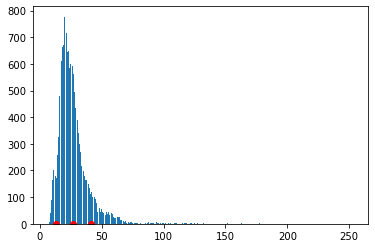

In [25]:
plt.hist(t, bins = 300)
t_std = np.std(t)
t_mean = np.mean(t)
plt.plot(t_mean, 0, 'ro')
plt.plot([t_mean-t_std, t_mean+ t_std], [0, 0], 'ro')
print(t_std)
print(t_mean)
t_max = round(t_mean + t_std)
print(t_max)

In [226]:
x, y = load_cut('train', tar, 'train', t_max=t_max)
test = load_cut('test', tar, 'test', t_max=t_max)

In [227]:
X = []
im_size = x[0].shape
for xi in x:
    f = np.zeros((im_size[0], im_size[1], 2))
    o = np.expand_dims(xi, axis = 2)
    X.append(np.append(o, f, axis = 2))


In [228]:
T = []
for ti in test:
    f = np.zeros((im_size[0], im_size[1], 2))
    o = np.expand_dims(ti, axis = 2)
    T.append(np.append(o, f, axis = 2))

In [229]:
np.array(X).shape

(13936, 128, 41, 3)

In [230]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_val, y_train, y_val = train_test_split(np.array(X), np.array(y), random_state=42, test_size=0.23)


In [231]:
X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
X_val = np.array((X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val)))
X_train = X_train/np.std(X_train)
X_val = X_val/np.std(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [238]:
T = np.array((T-np.min(T))/(np.max(T)-np.min(T)))
T = T/np.std(T)

In [232]:
import tensorflow as tf
from tensorflow.keras import models, layers

input_shape=(128,t_max,3)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(24, activation='softmax'))
CNNmodel.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 126, 39, 32)       896       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 63, 19, 32)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 63, 19, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 61, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 30, 8, 64)         0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 30, 8, 64)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 28, 6, 64)       

In [233]:
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [234]:
history = CNNmodel.fit(X_train, y_train, epochs=20, validation_data= (X_val, y_val))

Epoch 1/20


2022-03-23 20:02:02.932674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


336/336 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.8267

2022-03-23 20:02:11.768508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


336/336 [==============================] - 10s 28ms/step - loss: 0.4638 - accuracy: 0.8267 - val_loss: 0.2062 - val_accuracy: 0.9404
Epoch 2/20
336/336 [==============================] - 8s 25ms/step - loss: 0.2044 - accuracy: 0.9304 - val_loss: 0.1712 - val_accuracy: 0.9448
Epoch 3/20
336/336 [==============================] - 8s 25ms/step - loss: 0.1595 - accuracy: 0.9463 - val_loss: 0.1314 - val_accuracy: 0.9557
Epoch 4/20
336/336 [==============================] - 8s 25ms/step - loss: 0.1310 - accuracy: 0.9579 - val_loss: 0.1255 - val_accuracy: 0.9529
Epoch 5/20
336/336 [==============================] - 8s 25ms/step - loss: 0.0985 - accuracy: 0.9660 - val_loss: 0.0912 - val_accuracy: 0.9716
Epoch 6/20
336/336 [==============================] - 8s 25ms/step - loss: 0.0994 - accuracy: 0.9665 - val_loss: 0.1024 - val_accuracy: 0.9641
Epoch 7/20
336/336 [==============================] - 8s 25ms/step - loss: 0.0775 - accuracy: 0.9716 - val_loss: 0.0747 - val_accuracy: 0.9726
Epoch 8/2

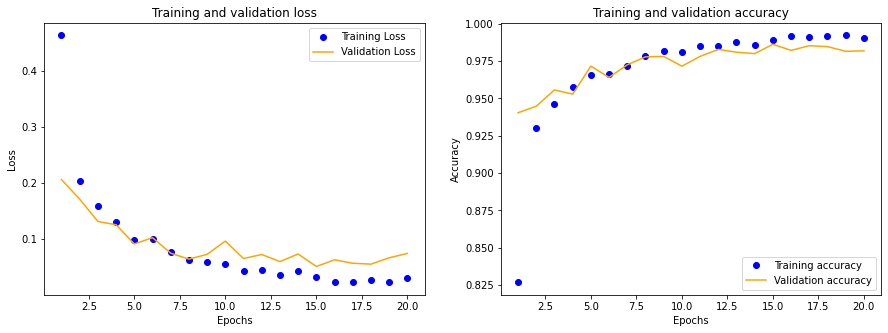

In [236]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,21)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [237]:
CNNmodel.save("CNNmodel_1")

INFO:tensorflow:Assets written to: CNNmodel_1/assets
